In [307]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
import gpytorch

#! Use this to get an idea on how it functions, this does not represent it properly.
#! It works well, still has crucial missing steps 

"""
# Evaluating the network on the validation set 
val_outputs = model(x_test)
val_loss = criterion(val_outputs, y_test)
print(val_loss)
"""

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Synthetic Data Frame

In [308]:
complexity = 1

# Forming the Training LF and HF Points
def lf(y):
    # return 0.5 * (6 * y - 2)**2 * np.sin(12 * y - 4) + 10 * (y - 0.5) - 5
    return 0.5 * (6 * y - 2)**2 * np.sin(12 * y - 4) + 10 * (y - 0.5) - 5
    
def hf(y): 
    # return (6 * y - 2)**2 * np.sin(12 * y - 4)
    return (6 * y - 2)**2 * np.sin(12 * y - 4) 

# Data Array
X = torch.linspace(0, complexity, 1000)[:,np.newaxis]



# Number of HF and LF points
Nhf = 8
Nlf = 20

# LF and HF training points
x_LF_train_np = np.linspace(0, complexity, Nlf)
x_LF_train = torch.linspace(0, complexity, Nlf)[:,np.newaxis]

x_HF_train = torch.linspace(min(x_LF_train_np), max(x_LF_train_np), Nhf)[:,np.newaxis]

y_LF_train = lf(x_LF_train)
y_HF_train = hf(x_HF_train)

# Hyper Parameters


In [309]:
# LF NN Hyper Paramters
LF_num_epochs = 800
LF_hidden_dims = ([400, 400, 400, 400, 400])

# HF NN Hyper Paramters
HF_num_epochs = 800
HF_hidden_dims = ([400, 400, 400, 400, 400, 400, 400])

# MFNN Hyper Paramters
MF_num_epochs = 400
MF_hidden_dims = ([400, 400, 400, 400, 400, 400, 400])

In [310]:
# LF NN Hyper Paramters
input_dim = 1
output_dim = 1

# Low Fidelity Neural Network
class NeuralNetwork(torch.nn.Module):
  def __init__(self, input_dim, LF_hidden_dims, output_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(input_dim, LF_hidden_dims[0])
    self.fc2 = torch.nn.Linear(LF_hidden_dims[0], LF_hidden_dims[1])
    self.fc3 = torch.nn.Linear(LF_hidden_dims[1], LF_hidden_dims[2])
    self.fc4 = torch.nn.Linear(LF_hidden_dims[2], LF_hidden_dims[3])
    self.fc5 = torch.nn.Linear(LF_hidden_dims[3], output_dim)
    # self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    # x = self.dropout(x)
    x = self.fc5(x)
    return x

LF_model = NeuralNetwork(input_dim, LF_hidden_dims, output_dim).to(device)

for param in LF_model.parameters():
  param.requires_grad = True

In [311]:
# Low Fidelity Model Training

# Define the criterion and optimizer
criterion = torch.nn.MSELoss().to(device) # Fixed Criterion for both Networks
LF_optimizer = torch.optim.Adam(LF_model.parameters())

# Training Step
LF_losses = []
for epoch in range(LF_num_epochs):
  LF_y_pred = LF_model(x_LF_train.to(device))
  LF_loss = criterion(LF_y_pred, y_LF_train.to(device))
  LF_losses.append(LF_loss.item())
  LF_optimizer.zero_grad()
  LF_loss.backward()
  LF_optimizer.step()

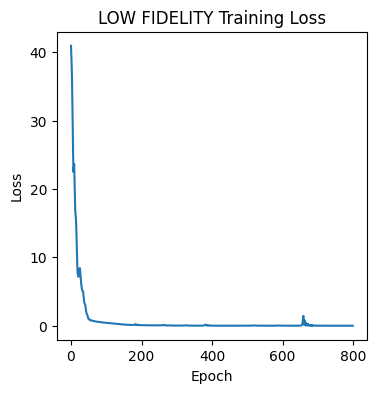

Final loss value:  0.001852364162914455


In [312]:
# Plotting the Loss Change for LF Model
plt.figure(figsize = (4, 4))
plt.plot(LF_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LOW FIDELITY Training Loss')
plt.show()

print("Final loss value: ", LF_loss.item())

In [313]:
# HF NN Hyper Paramters
input_dim = 1

# High Fidelity Neural Network
# class HighFidelityNetwork(torch.nn.Module):
#   def __init__(self, input_dim, HF_hidden_dims, output_dim):
#     super().__init__()
#     self.fc1 = torch.nn.Linear(input_dim, HF_hidden_dims[0])
#     self.fc2 = torch.nn.Linear(HF_hidden_dims[0], HF_hidden_dims[1])
#     self.fc3 = torch.nn.Linear(HF_hidden_dims[1], HF_hidden_dims[2])
#     self.fc4 = torch.nn.Linear(HF_hidden_dims[2], HF_hidden_dims[3])
#     self.fc5 = torch.nn.Linear(HF_hidden_dims[3], output_dim)
#     # self.dropout = nn.Dropout(0.2)

#   def forward(self, x):
#     x = torch.relu(self.fc1(x))
#     x = torch.relu(self.fc2(x))
#     x = torch.relu(self.fc3(x))
#     x = torch.relu(self.fc4(x))
#     # x = self.dropout(x)
#     x = self.fc5(x)
#     return x

# HF_model = HighFidelityNetwork(input_dim, HF_hidden_dims, output_dim).to(device)

# for param in HF_model.parameters():
#   param.requires_grad = True



########################################### 
train_x = torch.linspace(min(x_LF_train_np), max(x_LF_train_np), Nhf)
train_y = hf(train_x)

class ExactGPModel_HF(gpytorch.models.ExactGP): 
    def __init__(self, train_x, train_y, likelihood): 
        super(ExactGPModel_HF, self).__init__(train_x.to(device), train_y.to(device), likelihood.to(device)) 
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()+gpytorch.kernels.MaternKernel()+ gpytorch.kernels.RBFKernel()) 

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) # This is the object used to represent multivariate normal distributions.
        # multivariate Gaussian distribution, or joint normal distribution is a generalization of the one-dimensional normal distribution to higher dimensions.

likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
HF_model = ExactGPModel_HF(train_x, train_y, likelihood).to(device) 
########################################### 

In [314]:
# High Fidelity Model Training





########################################### 
HF_optimizer = torch.optim.Adam(HF_model.parameters(),lr=0.1, weight_decay=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, HF_model)

HF_losses = []
for i in range(HF_num_epochs):
    # Zero gradients from previous iteration
    HF_optimizer.zero_grad()
    # Output from model
    output = HF_model(train_x.to(device))
    # Calc loss and backprop gradients
    loss = -mll(output, train_y.to(device))
    HF_losses.append(loss.item())
    loss.backward() 
    HF_optimizer.step()

 #! Making HF predictions with the HF model
HF_model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = X
    observed_pred = likelihood(HF_model(test_x.to(device)))
    
observed_pred_mean = observed_pred.mean

########################################### 

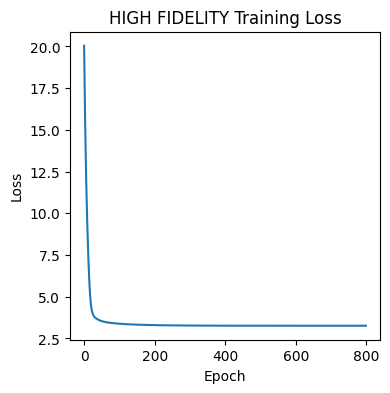

Final loss value:  3.2601404190063477


In [315]:
# Plotting the Loss Change for LF Model
plt.figure(figsize = (4, 4))
plt.plot(HF_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('HIGH FIDELITY Training Loss')
plt.show()

print("Final loss value: ", loss.item())

In [316]:
# Step 1: Predict HF points with LF Model
# Step 2: Add X_HF Points and output of the predictions from Step 1
# Step 3: Create a Third NN Model fitting the new X_HF Array from Step 2 and Y_HF_TRAIN values
# Step 4: Add X...? and output of the LF model (similar to Step 2)
# Step 5: Predict this new arrray with the MFNN model from Step 3

In [317]:
# Step 1: Predict HF points with LF Model & Step 2: Add X_HF Points and output of the predictions from Step 1
L1mean = LF_model(x_HF_train.to(device))

print(L1mean.shape)

L2train = np.hstack((x_HF_train, L1mean.cpu().detach().numpy())) # think of the house price example (sqr feet, rooms, garden, etc.)
L2train = torch.from_numpy(L2train) 
print(L2train.shape)

torch.Size([8, 1])
torch.Size([8, 2])


In [318]:
# Step 3: Create a Third NN Model fitting the new X_HF Array from Step 2 and Y_HF_TRAIN values
# MFNN Hyper Paramters
input_dim = 2

# High Fidelity Neural Network
class MultiFidelityNetwork(torch.nn.Module):
  def __init__(self, input_dim, MF_hidden_dims, output_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(input_dim, MF_hidden_dims[0])
    self.fc2 = torch.nn.Linear(MF_hidden_dims[0], MF_hidden_dims[1])
    self.fc3 = torch.nn.Linear(MF_hidden_dims[1], MF_hidden_dims[2])
    self.fc4 = torch.nn.Linear(MF_hidden_dims[2], MF_hidden_dims[3])
    self.fc5 = torch.nn.Linear(MF_hidden_dims[3], MF_hidden_dims[3])
    self.fc6 = torch.nn.Linear(MF_hidden_dims[3], output_dim)
    # self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    # x = self.dropout(x)
    x = self.fc6(x)
    return x

MF_model = MultiFidelityNetwork(input_dim, MF_hidden_dims, output_dim).to(device)

for param in MF_model.parameters():
  param.requires_grad = True

In [319]:
# Multi Fidelity Model Training

# Define the optimizer
MF_optimizer = torch.optim.Adam(MF_model.parameters(),lr=0.0001)

# Training Step
MF_losses = []
for epoch in range(MF_num_epochs):
  MF_y_pred = MF_model(L2train.to(device))
  MF_loss = criterion(MF_y_pred, y_HF_train.to(device))
  MF_losses.append(MF_loss.item())
  MF_optimizer.zero_grad()
  MF_loss.backward()
  MF_optimizer.step()
  
for param in MF_model.parameters():
  param.requires_grad = True

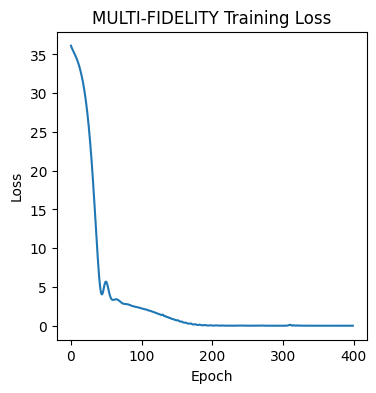

Final loss value:  0.00045299442717805505


In [320]:
# Plotting the Loss Change for LF Model
plt.figure(figsize = (4, 4))
plt.plot(MF_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MULTI-FIDELITY Training Loss')
plt.show()

print("Final loss value: ", MF_loss.item())

In [321]:
# Running the Models with LF and HF points
y_pred_lf = LF_model(X.to(device))
y_pred_hf = HF_model(X.to(device))
print(y_pred_lf.shape)
y_pred_hf = y_pred_hf.loc[:,None]
print(y_pred_hf.shape)

# Step 4: Add X...? and output of the LF model (similar to Step 2)
L2test = np.hstack((X, y_pred_lf.cpu().detach().numpy()))
L2test = torch.from_numpy(L2test)
print(L2test.shape)

# Step 5: Predict this new arrray with the MFNN model from Step 3
y_pred_mf = MF_model(L2test.to(device))

torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 2])


LF loss:  0.001852364162914455
HF loss:  3.2601404190063477
MF loss:  0.00045299442717805505


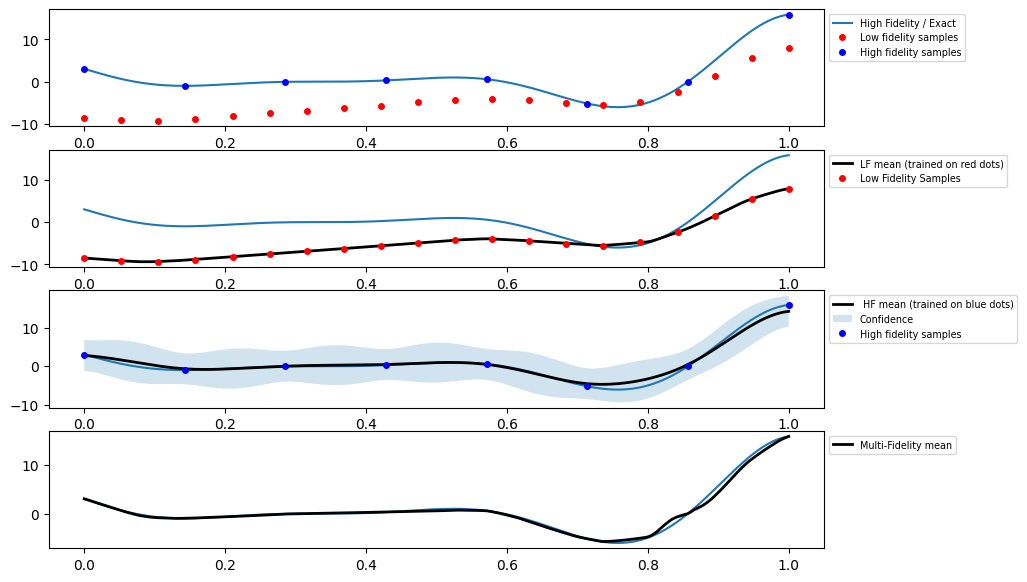

In [322]:
# Plotting the predictions against the true values after converting from CUDA to CPU's memory

lower,  upper  =  observed_pred.confidence_region()

fig, axs = plt.subplots(4, figsize = (10, 7))

axs[0].plot(X,hf(X), label= "High Fidelity / Exact") # main result line we want to match with
axs[0].plot(x_LF_train, lf(x_LF_train), 'ro', markersize = 4, label = "Low fidelity samples")
axs[0].plot(x_HF_train, hf(x_HF_train), 'bo', markersize = 4, label = "High fidelity samples")
axs[0].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')

axs[1].plot(X, hf(X)) 
axs[1].plot(X, y_pred_lf.cpu().detach().numpy(),'k', lw=2, label= "LF mean (trained on red dots)")
axs[1].plot(x_LF_train, lf(x_LF_train), 'ro', markersize = 4, label = 'Low Fidelity Samples')
axs[1].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')



axs[2].plot(X, hf(X))
axs[2].plot(X, y_pred_hf.cpu().detach().numpy(), 'k', lw=2, label=" HF mean (trained on blue dots)")
test_x= torch.linspace(0, complexity, 1000)
axs[2].fill_between(test_x.numpy(), lower.cpu().detach().numpy(), upper.cpu().detach().numpy(), alpha=0.2, label = "Confidence")
axs[2].plot(x_HF_train, hf(x_HF_train),'bo', markersize = 4, label="High fidelity samples")
axs[2].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')



axs[3].plot(X, hf(X))
axs[3].plot(X, y_pred_mf.cpu().detach().numpy(), 'k', lw=2, label="Multi-Fidelity mean")
axs[3].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')

print("LF loss: ", LF_loss.item())
print("HF loss: ", loss.item())
print("MF loss: ", MF_loss.item())